## 60. 単語ベクトルの読み込みと表示

In [1]:
from gensim.models import KeyedVectors

model: KeyedVectors = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)
# 実行に50秒弱かかる。

## 61. 単語の類似度

コサイン類似度について...  
要するにコサインのことらしい。
ベクトルの内積の求め方に2通りあることを利用すると簡単に算出できる。すなわち、`（ベクトルの要素同士をかけ合わせたものの合計）/（長さを全てかけ合わせたもの）＝コサイン`

もちろん実際には、ライブラリにn次元のベクトルを渡せば計算してくれる。


In [2]:
model.similarity('United_States', "U.S.")


0.73107743

In [3]:
print(model.similarity('United_States', "Canada"))
print(model.similarity('United_States', "Japan"))
print(model.similarity('United_States', "China"))
print(model.similarity('United_States', "Liberty"))
print(model.similarity('United_States', "Hamburger"))
print(model.similarity('United_States', "Hollywood"))
print(model.similarity('United_States', "Donald_Trump"))
print(model.similarity('United_States', "MLB"))
print(model.similarity('United_States', "NBA"))
print(model.similarity('United_States', "McDonald's"))
print(model.similarity('United_States', "BBQ"))
print(model.similarity('United_States', "Sushi"))


0.60190696
0.52173746
0.50480795
0.055387232
0.0290211
0.08729957
0.11877319
0.13579674
0.19138478
0.114507645
0.0017238103
-0.05492107


## 62. 類似度の高い単語10件

In [4]:
model.most_similar('United_States', topn=10)


[('Unites_States', 0.7877248525619507),
 ('Untied_States', 0.7541370987892151),
 ('United_Sates', 0.7400724291801453),
 ('U.S.', 0.7310774326324463),
 ('theUnited_States', 0.6404393911361694),
 ('America', 0.6178410053253174),
 ('UnitedStates', 0.6167312264442444),
 ('Europe', 0.6132988929748535),
 ('countries', 0.6044804453849792),
 ('Canada', 0.601906955242157)]

## 63. 加法構成性によるアナロジー

In [5]:
vec = model['Spain'] - model['madrid'] + model['Athens'] # スペインの首都はマドリード、ギリシャの首都はアテネ
model.most_similar(vec, topn=10)


[('Athens', 0.6826056838035583),
 ('Greece', 0.4856836199760437),
 ('Athens_Greece', 0.46644291281700134),
 ('Spain', 0.4448360204696655),
 ('Rome', 0.41419845819473267),
 ('Organising_Committee_ATHOC', 0.41101542115211487),
 ('prosecutor_Costas_Simitzoglou', 0.4097808599472046),
 ('bronze_medalist_Alicia_Molik', 0.3909006416797638),
 ('Greek', 0.39005470275878906),
 ('silver_medalist_Mardy_Fish', 0.38434845209121704)]

## 64. アナロジーデータでの実験

In [4]:
import pandas as pd
df = pd.read_csv('./data/questions-words.txt', sep=' ', header=None, names=['vec1', 'vec2', 'vec3', 'vec4'], skiprows=1)


In [7]:
df = df[df['vec1'].str.startswith(':') == False]

In [8]:
from typing import Tuple

def get_most_similar_word_and_similarity(word: str) -> Tuple[str, float]:
    return model.most_similar(word, topn=1)


In [9]:
vec1: pd.Series = df[0:10]['vec1']
df_most_similar_word_and_similarity = vec1.map(get_most_similar_word_and_similarity) # WIP: 本当は2列にしたかった


## 65. アナロジータスクでの正解率

In [10]:
semantic = df[df.index <= 8872] # 手抜き
syntactic = df[df.index > 8872]


## 66. WordSimilarity-353での評価

In [11]:
word_sim_df = pd.read_csv('./data/wordsim353/set1.csv', sep=',')


In [12]:
def get_similarity(row):
    # print(row['Word 1'], row['Word 2'])
    return model.similarity(row['Word 1'], row['Word 2'])


In [13]:
word_sim_df['Machine'] = word_sim_df[['Word 1', 'Word 2',]].apply(lambda row: get_similarity(row), axis=1)
word_sim_df.head()

,Word 1,Word 2,Human (mean),1,2,3,4,5,6,7,8,9,10,11,12,13,Machine
0,love,sex,6.77,9.0,6.0,8.0,8,7,8,8.0,4,7.0,2,6.0,7,8,0.263938
1,tiger,cat,7.35,9.0,7.0,8.0,7,8,9,8.5,5,6.0,9,7.0,5,7,0.517296
2,tiger,tiger,10.00,10.0,10.0,10.0,10,10,10,10.0,10,10.0,10,10.0,10,10,1.000000
3,book,paper,7.46,8.0,8.0,7.0,7,8,9,7.0,6,7.0,8,9.0,4,9,0.363463
4,computer,keyboard,7.62,8.0,7.0,9.0,9,8,8,7.0,7,6.0,8,10.0,3,9,0.396392


In [14]:
word_sim_df[['Human (mean)', 'Machine']].corr(method='spearman')

,Human (mean),Machine
Human (mean),1.000000,0.665139
Machine,0.665139,1.000000


## 67. k-meansクラスタリング

In [2]:
import geopandas
world_raw = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_raw

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,KOS,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [4]:
world = world_raw[world_raw['name'].isin(model.index_to_key)]
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
6,33580650.0,Asia,Uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586..."
...,...,...,...,...,...,...
168,44269594.0,Africa,Uganda,UGA,35165,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736..."
169,12626950.0,Africa,Rwanda,RWA,10354,"POLYGON ((30.41910 -1.13466, 30.81613 -1.69891..."
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."


In [5]:
world['vector'] = world.apply(lambda row: model[row['name']], axis=1)
world.to_pickle('data/dst/world_obj.zip')
world

/Users/hiroga/.ghq/github.com/xhiroga/til/computer-science/nlp/nlp100/.venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,vector
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...","[-0.04638672, -0.3125, 0.09423828, -0.3984375,..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...","[0.0390625, 0.12109375, -0.072265625, 0.100097..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...","[-0.13671875, -0.15429688, 0.26953125, 0.27343..."
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...","[-0.27148438, -0.07128906, 0.018066406, 0.0427..."
6,33580650.0,Asia,Uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...","[-0.07421875, -0.08251953, 0.29492188, 0.08544..."
...,...,...,...,...,...,...,...
168,44269594.0,Africa,Uganda,UGA,35165,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736...","[0.16699219, 0.13378906, -0.001335144, 0.05786..."
169,12626950.0,Africa,Rwanda,RWA,10354,"POLYGON ((30.41910 -1.13466, 30.81613 -1.69891...","[0.024536133, 0.17871094, 0.19824219, -0.00109..."
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...","[0.118652344, -0.06347656, 0.28125, -0.0116577..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...","[0.07519531, -0.20996094, 0.17871094, -0.05249..."


/Users/hiroga/.ghq/github.com/xhiroga/til/computer-science/nlp/nlp100/.venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

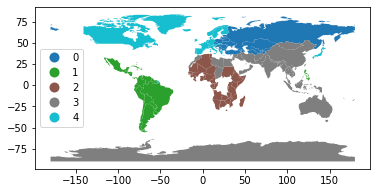

In [7]:
from sklearn import cluster

NUM_CLUSTERS=5
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(world['vector'].to_list())
world['label'] = kmeans.labels_
world.plot(column='label', categorical=True, legend=True, legend_kwds={'loc': 'center left'})


## 67. k-meansクラスタリング（別解）

In [19]:
countries_df = pd.read_csv('./data/google-countries.tsv', sep='\t')
countries_df.head()


,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [20]:
countries_df = countries_df[countries_df['name'].isin(model.key_to_index)]
countries_df['vector'] = countries_df.apply(lambda row: model[row['name']], axis=1)
countries_df.head()

,country,latitude,longitude,name,vector
0,AD,42.546245,1.601554,Andorra,"[-0.05102539, -0.44921875, -0.13964844, 0.2041..."
2,AF,33.939110,67.709953,Afghanistan,"[-0.057373047, 0.038330078, 0.026000977, 0.206..."
4,AI,18.220554,-63.068615,Anguilla,"[-0.15429688, -0.24316406, -0.20800781, -0.129..."
5,AL,41.153332,20.168331,Albania,"[-0.014038086, -0.1015625, 0.24023438, 0.02832..."
6,AM,40.069099,45.038189,Armenia,"[0.027832031, -0.08203125, 0.24804688, 0.22558..."


In [21]:
from sklearn import cluster

NUM_CLUSTERS=5
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(countries_df['vector'].to_list())


KMeans(n_clusters=5)

In [22]:
countries_df['label'] = kmeans.labels_
countries_df

,country,latitude,longitude,name,vector,label
0,AD,42.546245,1.601554,Andorra,"[-0.05102539, -0.44921875, -0.13964844, 0.2041...",4
2,AF,33.939110,67.709953,Afghanistan,"[-0.057373047, 0.038330078, 0.026000977, 0.206...",0
4,AI,18.220554,-63.068615,Anguilla,"[-0.15429688, -0.24316406, -0.20800781, -0.129...",3
5,AL,41.153332,20.168331,Albania,"[-0.014038086, -0.1015625, 0.24023438, 0.02832...",4
6,AM,40.069099,45.038189,Armenia,"[0.027832031, -0.08203125, 0.24804688, 0.22558...",4
...,...,...,...,...,...,...
239,XK,42.602636,20.902977,Kosovo,"[0.1875, -0.20507812, 0.056396484, 0.2734375, ...",4
240,YE,15.552727,48.516388,Yemen,"[0.13867188, 0.037353516, -0.36523438, 0.28515...",0
241,YT,-12.827500,45.166244,Mayotte,"[0.28320312, 0.107910156, 0.041015625, 0.01953...",2
243,ZM,-13.133897,27.849332,Zambia,"[-0.033691406, 0.076660156, 0.008239746, 0.010...",2


## 68. Ward法によるクラスタリング

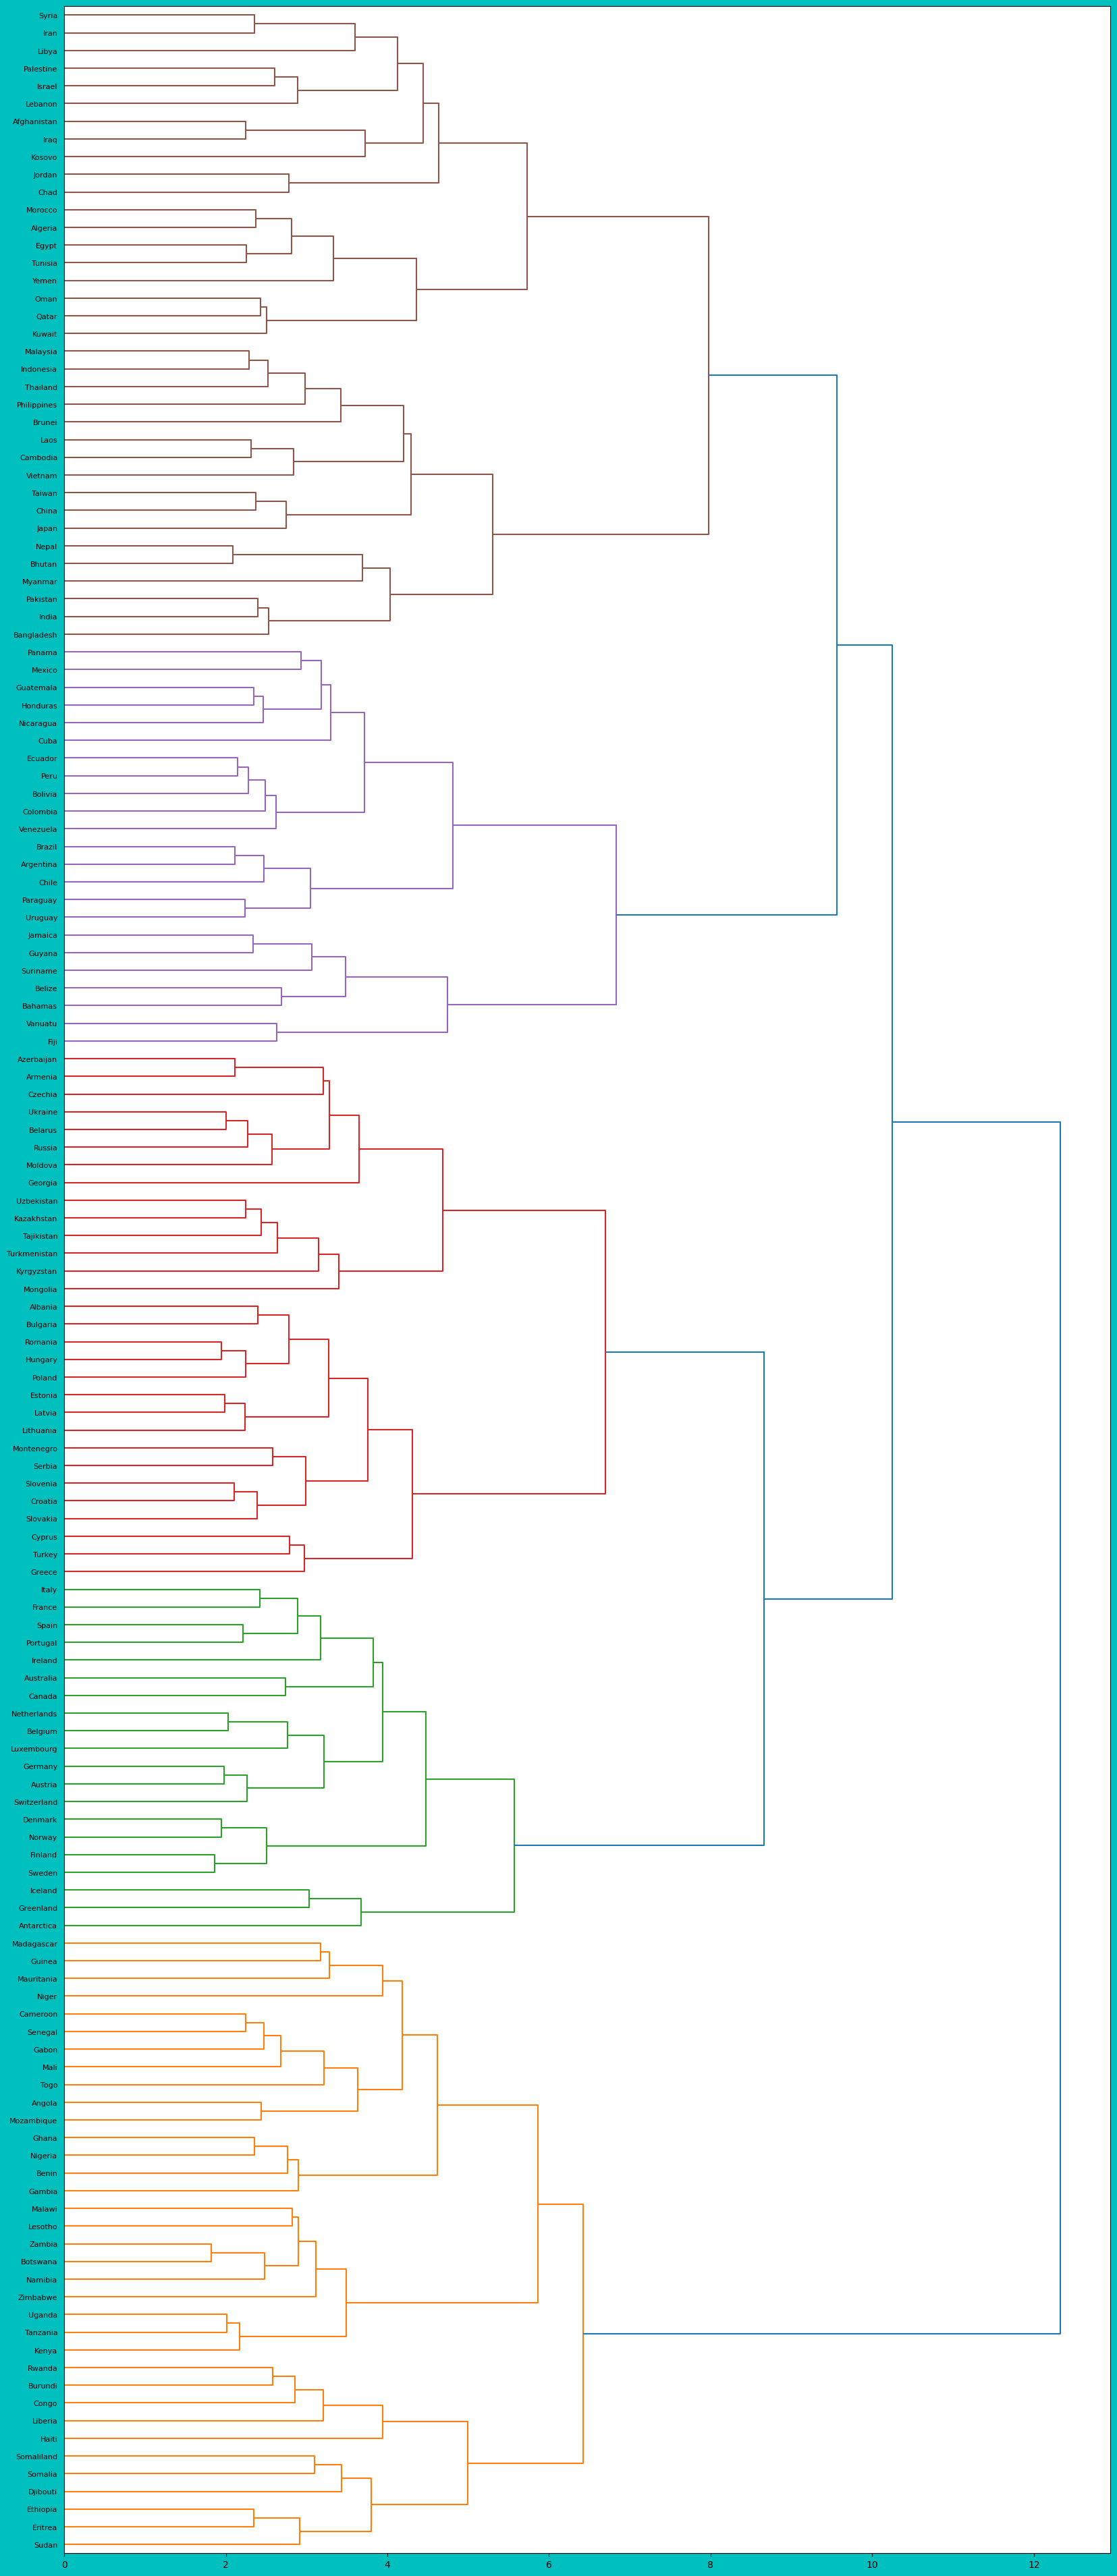

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage

world = pd.read_pickle('data/dst/world_obj.zip')
world_vector = world['vector']
clustered = linkage(world['vector'].tolist(), method='ward')
plt.figure(figsize=(20, 50), dpi=100, facecolor='c')
dendrogram(clustered, labels=world['name'].tolist(), leaf_font_size=8, orientation='right')
plt.show()


## 68. Ward法によるクラスタリング（別解: 次元削減してから実行）

In [6]:
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

world = pd.read_pickle("data/dst/world_obj.zip")

pca = PCA(n_components=3)
vector_3d = pd.DataFrame(pca.fit_transform(world["vector"].tolist()))

fig = px.scatter_3d(vector_3d, x=0, y=1, z=2)
fig.show()


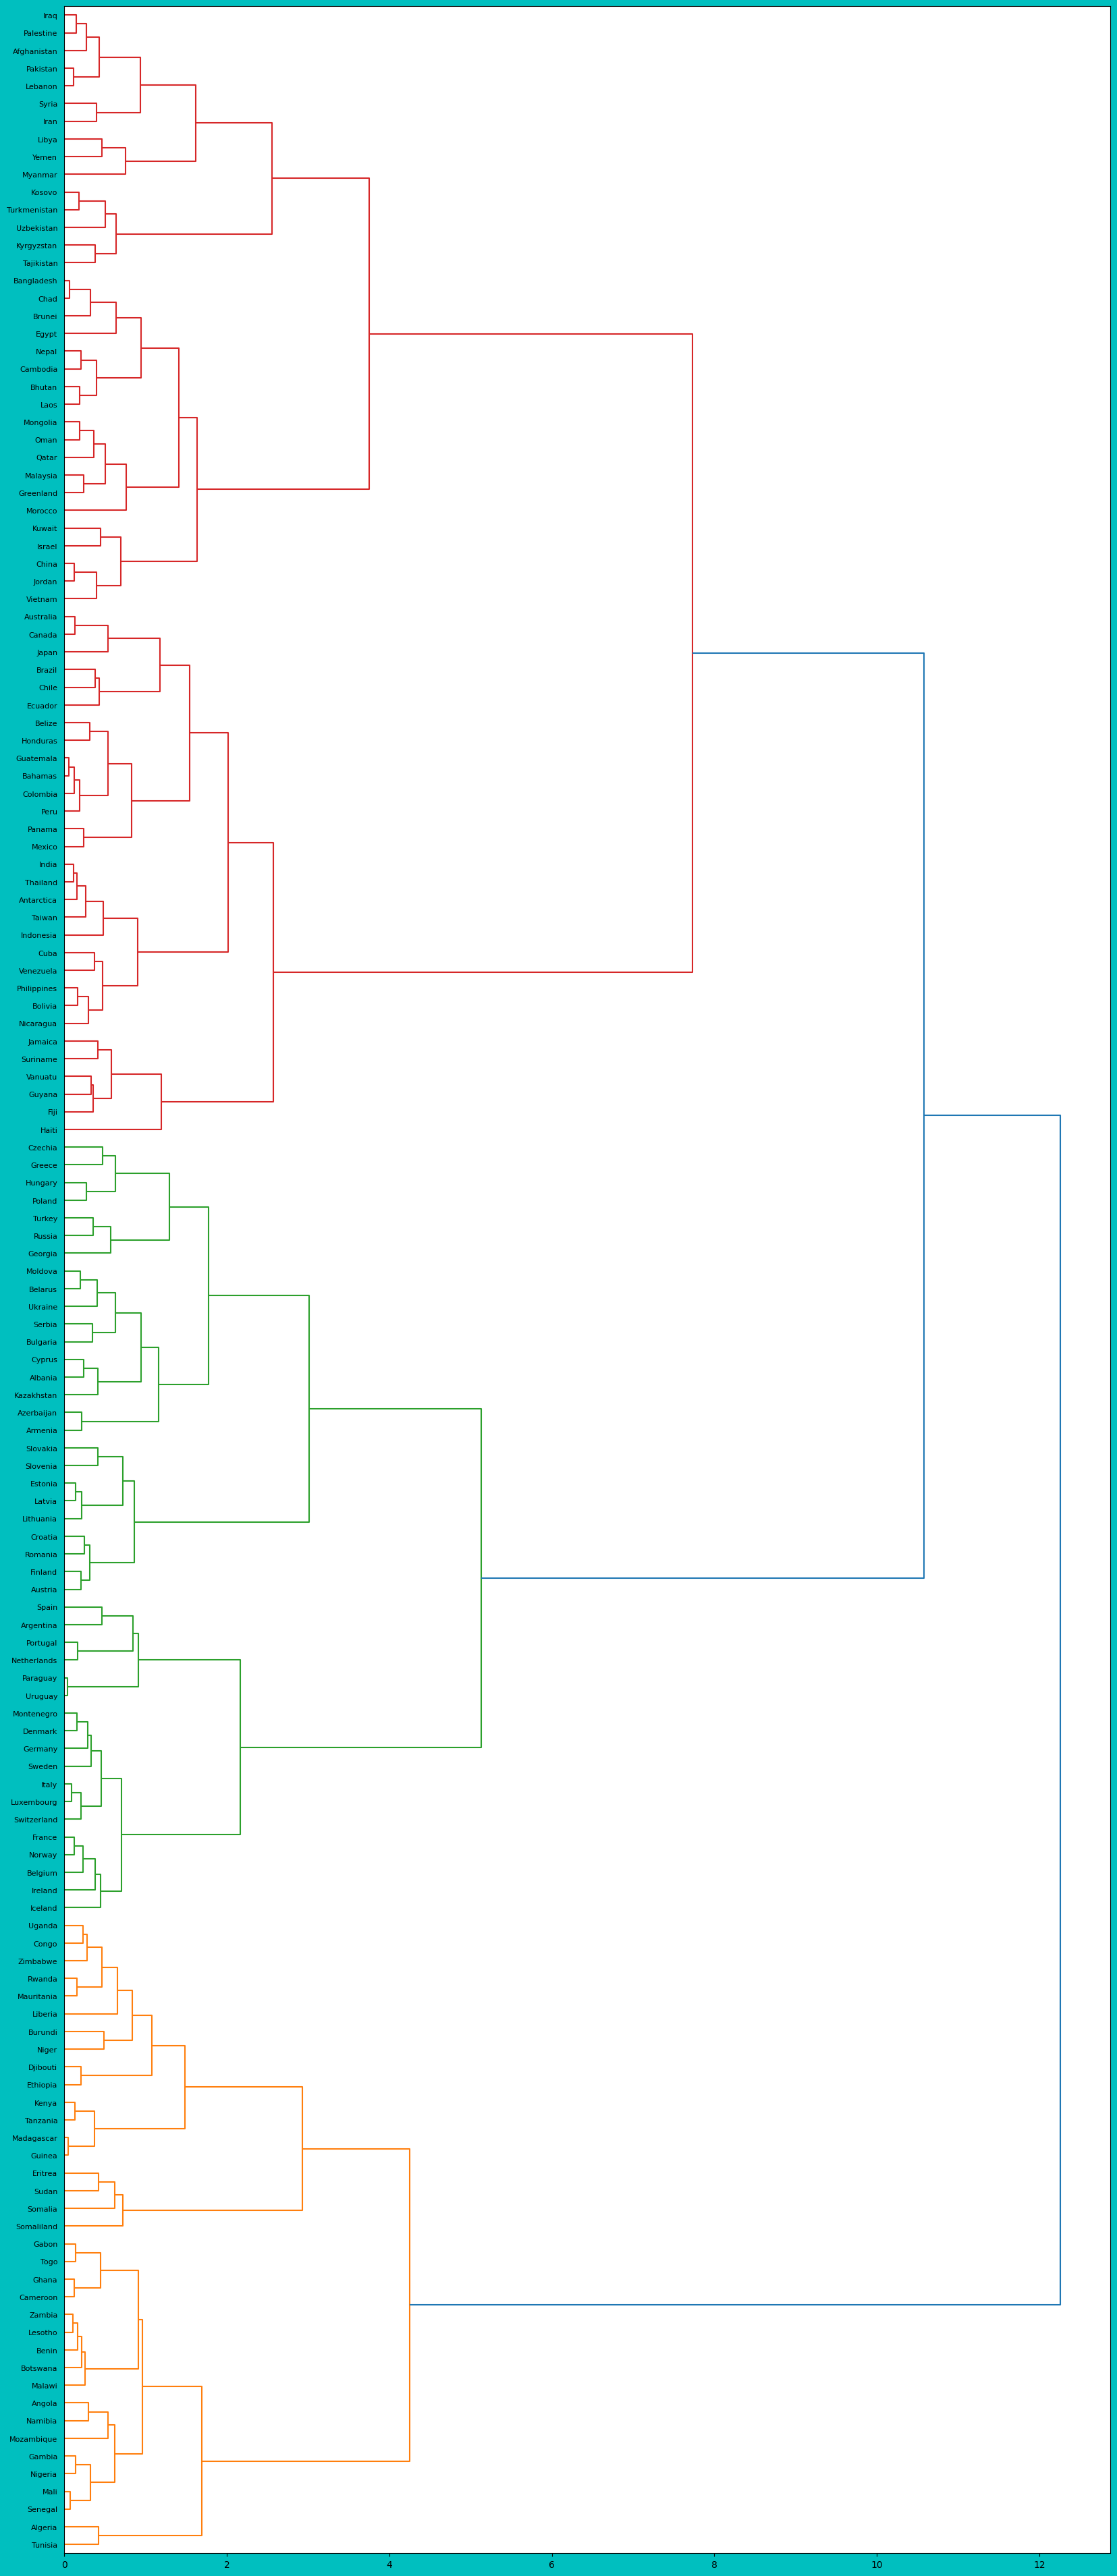

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage

world = pd.read_pickle('data/dst/world_obj.zip')
clustered = linkage(vector_3d.values.tolist(), method='ward', )
plt.figure(figsize=(20, 50), dpi=100, facecolor='c')
dendrogram(clustered, labels=world['name'].tolist(), leaf_font_size=8, orientation='right')
plt.show()

# それなりに納得感があるクラスタリングになっている。

## 69. t-SNEによる可視化

In [31]:
from tkinter import E
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

world = pd.read_pickle('data/dst/world_obj.zip')

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
X_embedded = tsne.fit_transform(world['vector'].to_list())
df = pd.DataFrame(X_embedded, columns=['2d_vector_x', '2d_vector_y'])
world['2d_vector_x'] = df['2d_vector_x']
world['2d_vector_y'] = df['2d_vector_y']

world.head()

/Users/hiroga/.ghq/github.com/xhiroga/til/computer-science/nlp/nlp100/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/hiroga/.ghq/github.com/xhiroga/til/computer-science/nlp/nlp100/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry,vector,2d_vector_x,2d_vector_y
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...","[-0.04638672, -0.3125, 0.09423828, -0.3984375,...",-11.451304,-2.268182
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...","[0.0390625, 0.12109375, -0.072265625, 0.100097...",-4.301219,-7.592407
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...","[-0.13671875, -0.15429688, 0.26953125, 0.27343...",8.358828,10.658307
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...","[-0.27148438, -0.07128906, 0.018066406, 0.0427...",-1.097254,0.311092
6,33580650.0,Asia,Uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...","[-0.07421875, -0.08251953, 0.29492188, 0.08544...",-4.208731,6.235786


In [42]:
world['continent'].unique()
colors = { 'Oceania': 'red', 'Africa': 'blue', 'North America': 'green', 'Asia': 'orange', 'South America': 'purple', 'Europe': 'pink', 'Antarctica': 'white' }

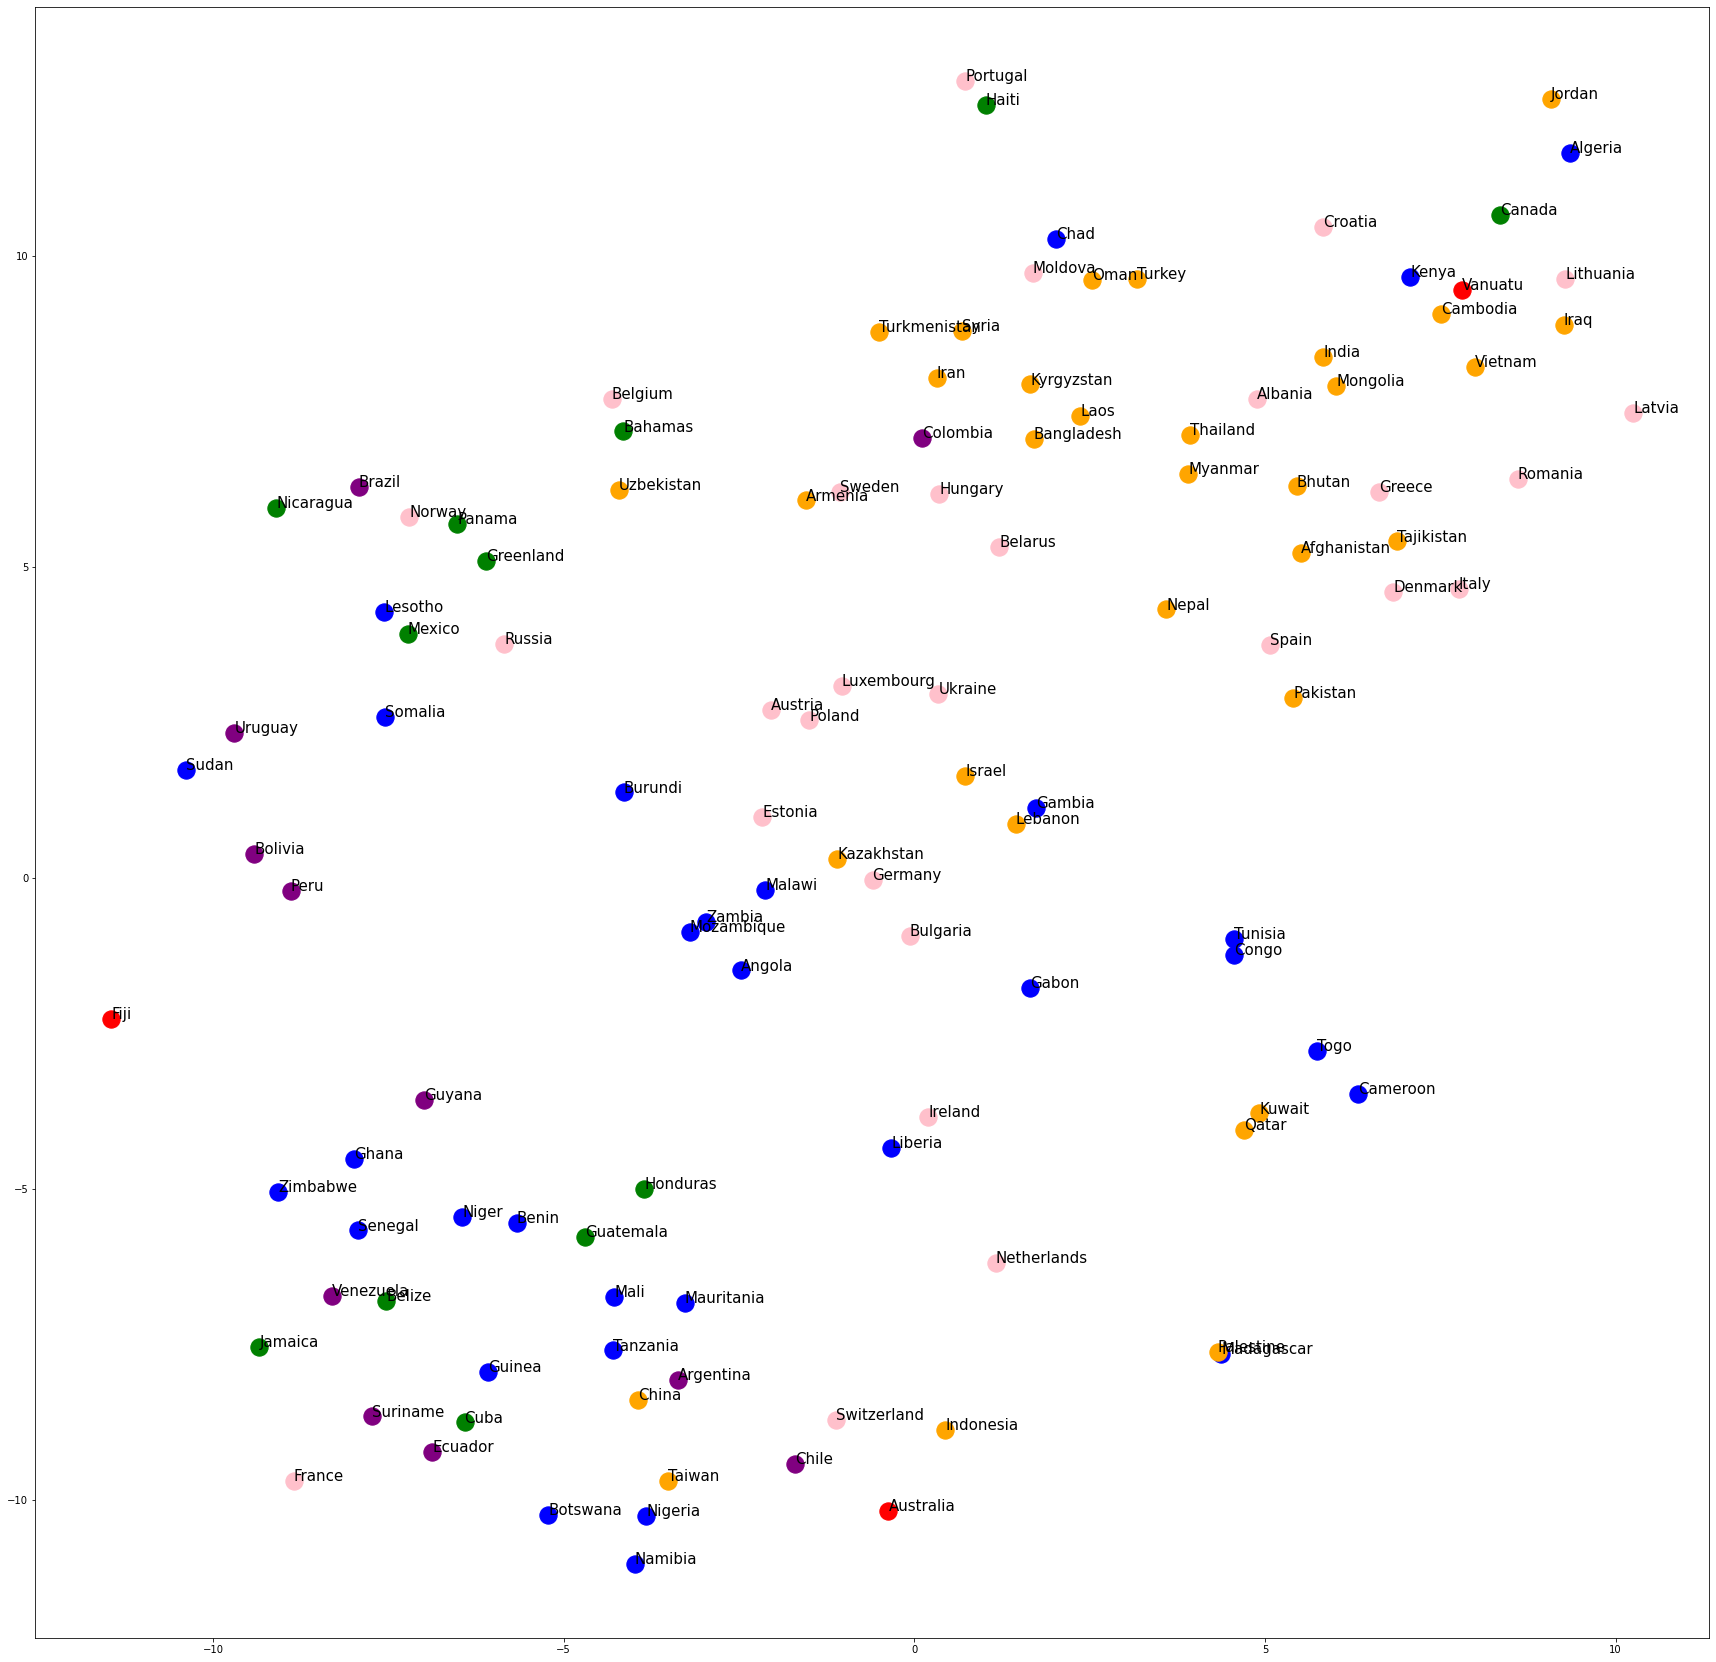

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
for index, row in world.iterrows():
    plt.scatter(row['2d_vector_x'], row['2d_vector_y'], color=colors[row['continent']], s=300)
    plt.annotate(row['name'], (row['2d_vector_x'], row['2d_vector_y']), fontsize=15)


## References

- [countries\.csv  \|  Dataset Publishing Language  \|  Google Developers](https://developers.google.com/public-data/docs/canonical/countries_csv)
- [【言語処理100本ノック 2020】 7章をPythonで解いた \- ギークなエンジニアを目指す男](https://www.takapy.work/entry/2021/06/20/191606)
- [言語処理100本ノック2020年版を解いてみた【第7章：単語ベクトル 67】 \| DevLog](https://www.soh-devlog.tokyo/nlp100-7-67/)
- [K Means Clustering Example with Word2Vec in Data Mining or Machine Learning \- Text Analytics Techniques](https://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/)
- [t\-SNEを理解して可視化力を高める \- Qiita](https://qiita.com/g-k/items/120f1cf85ff2ceae4aba)